In [38]:
import tensorflow_datasets as tfds
import tensorflow as tf
import logging, os
import pandas as pd
import time
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"cats_vs_dogs_transfer/"
os.system("mkdir -p " + OUTPUT_PATH)


train_dataset, validation_dataset = tfds.load(
    "cats_vs_dogs",
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,  # Include labels
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_test = tf.data.experimental.cardinality(validation_dataset)

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")

size = (150, 150)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
validation_dataset = validation_dataset.map(lambda x, y: \
                                  (tf.image.resize(x, size), y))

batch_size = 32

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache() \
    .batch(batch_size).prefetch(buffer_size=10)

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Number of training samples: 9305
Number of validation samples: 2326


In [39]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. 
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, 
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                           

In [40]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 4
history =model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/4
142/291 [=============>................] - ETA: 2s - loss: 0.2059 - binary_accuracy: 0.9060

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


259/291 [=========================>....] - ETA: 0s - loss: 0.1728 - binary_accuracy: 0.9246

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


274/291 [===========================>..] - ETA: 0s - loss: 0.1693 - binary_accuracy: 0.9262

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


289/291 [============================>.] - ETA: 0s - loss: 0.1668 - binary_accuracy: 0.9277

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 9s 24ms/step - loss: 0.1671 - binary_accuracy: 0.9279 - val_loss: 0.0866 - val_binary_accuracy: 0.9699
Epoch 2/4
291/291 [==============================] - 6s 21ms/step - loss: 0.1197 - binary_accuracy: 0.9485 - val_loss: 0.0776 - val_binary_accuracy: 0.9712
Epoch 3/4
291/291 [==============================] - 6s 21ms/step - loss: 0.1118 - binary_accuracy: 0.9550 - val_loss: 0.0817 - val_binary_accuracy: 0.9669
Epoch 4/4
291/291 [==============================] - 6s 22ms/step - loss: 0.1041 - binary_accuracy: 0.9545 - val_loss: 0.0721 - val_binary_accuracy: 0.9721


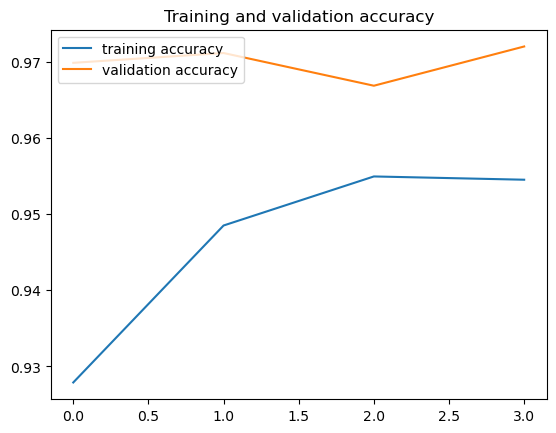

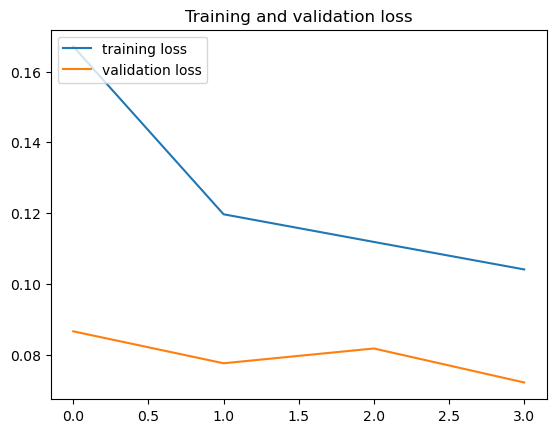

In [41]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'binary_accuracy' ]
val_acc  = history.history[ 'val_binary_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_plot   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs_plot,     acc , label="training accuracy")
plt.plot  ( epochs_plot, val_acc, label="validation accuracy" )
plt.title ('Training and validation accuracy')
plt.legend(loc="upper left")
plt.savefig(OUTPUT_PATH + "accuracy.png")
plt.figure()


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs_plot,     loss , label="training loss")
plt.plot  ( epochs_plot, val_loss , label="validation loss" )
plt.legend(loc="upper left")
plt.title ('Training and validation loss'   )
plt.savefig(OUTPUT_PATH + "loss.png")

In [42]:
# Make predictions
predictions = model.predict(validation_dataset)
allpreds=predictions.flatten()
allpnorms = np.where(allpreds > 0.5, 1, 0)

alllabels=np.empty(0)
for images, labels in validation_dataset:
    alllabels = np.append(alllabels, labels.numpy().flatten())

score = metrics.accuracy_score(alllabels, allpnorms)
print("test dataset accuracy score: {}".format(score))

collabels = pd.DataFrame(alllabels, columns=["l"])
colpreds = pd.DataFrame( allpreds, columns=["pred"])
pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
diff = collabels["l"] - pnorm["pnorm"]

compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
compare.columns = ["l", "pred", "pnorm","diff"]
print(compare)

compare.to_csv(OUTPUT_PATH + "pred_test_fit.csv", index=False)   

73/73 [==============================] - 1s 13ms/step
test dataset accuracy score: 0.9720550300945829
        l      pred  pnorm  diff
0     0.0 -8.700836      0   0.0
1     1.0  4.693343      1   0.0
2     0.0 -9.341220      0   0.0
3     0.0 -2.910272      0   0.0
4     1.0  0.659717      1   0.0
...   ...       ...    ...   ...
2321  0.0 -7.481091      0   0.0
2322  0.0 -6.783258      0   0.0
2323  1.0  4.570061      1   0.0
2324  1.0  6.784830      1   0.0
2325  0.0 -6.564024      0   0.0

[2326 rows x 4 columns]


In [43]:
# Save model
timestr = time.strftime("%Y%m%d-%H%M%S")
acc=val_acc[-1] # last element
filename = f"valacc_{score:.3f}_epochs_{epochs}_date_{timestr}.h5"
fullpath = f"{OUTPUT_PATH}{filename}"
print("Saving model to ", filename)
model.save(fullpath)

Saving model to  valacc_0.972_epochs_4_date_20250726-214355.h5


/media/data/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

# base_model.trainable = True
# model.summary()
# model.compile(
# optimizer=keras.optimizers.Adam(1e-5), # Low learning rate
# loss=keras.losses.BinaryCrossentropy(from_logits=True),
# metrics=[keras.metrics.BinaryAccuracy()],
# )
# epochs = 10
# model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
